In [1]:
%load_ext autoreload
%autoreload 2
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from shapely import Point

from ocr import catalog
from ocr.config import OCRConfig
from ocr.risks.fire import (
    generate_wind_directional_kernels,
    get_grid_spacing_info,
)

warnings.filterwarnings('ignore')

In [2]:
config = OCRConfig(storage_root='/tmp/ocr-testing', debug=True)

In [3]:
region_id = 'y6_x7'
y_slice, x_slice = config.chunking.region_id_to_latlon_slices(region_id=region_id)
y_slice, x_slice

(slice(np.float64(33.515893851345204), np.float64(35.363857121965516), None),
 slice(np.float64(-118.68574904867506), np.float64(-117.29977659570983), None))

In [4]:
def load_conus_results(version):
    # Configure S3 storage for the Icechunk repository
    import icechunk

    storage = icechunk.s3_storage(
        bucket='carbonplan-ocr',
        prefix=f'output/fire-risk/tensor/production/{version}/ocr.icechunk',
        anonymous=True,
    )

    # Open the repository
    repo = icechunk.Repository.open(storage)

    # Create a read-only session on the main branch
    session = repo.readonly_session('main')
    return xr.open_zarr(session.store)

In [5]:
# Load in datasets for comparison
ds_before = load_conus_results('v1.0.0')
ds_after = load_conus_results('v1.1.0')
diff = ds_after - ds_before

In [6]:
# Load wind direction distribution for this region
wind_dist = (
    catalog.get_dataset('conus404-ffwi-p99-wind-direction-distribution-30m-4326')
    .to_xarray()
    .wind_direction_distribution
)

In [7]:
subset = wind_dist.sel(latitude=y_slice, longitude=x_slice)

In [8]:
latitude, longitude, latitude_increment, longitude_increment = get_grid_spacing_info(subset)

In [9]:
latitude, longitude, latitude_increment, longitude_increment

(np.float64(34.440029483520405),
 np.float64(-117.99260882531743),
 np.float64(0.00030799387843671866),
 np.float64(0.00030799387843671866))

In [10]:
# specify coordinates of locations you want to inspect
locations = {
    'griffith': [34.15883207704988, -118.3194545446337],
    'altadena': [34.197179348047236, -118.14920706081259],
    'paradise': [39.81028, -121.43722],
    'marshall': [39.95, -105.15],
    'woolsey-malibu': [34.2350, -118.7013],
    'leavenworth': [47.59623, -120.66148],
    'spokane': [47.64, -117.44],
}

In [11]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
states = states[~(states['STUSPS'].isin(['AK', 'PR', 'HI']))]

In [12]:
def evaluate_bounding_box_before_after(lat_slice, lon_slice, ds_before, ds_after, title=None):
    fig, axarr = plt.subplots(nrows=2, ncols=8, figsize=(32, 8))

    # Row 1: Before and After absolute values
    # burn probability
    bp_ax = ds_before.sel(latitude=lat_slice, longitude=lon_slice).bp_2011.plot(ax=axarr[0, 0])
    axarr[0, 0].set_title('Before BP 2011')

    ds_after.sel(latitude=lat_slice, longitude=lon_slice).bp_2011.plot(
        ax=axarr[0, 1], vmin=bp_ax.get_clim()[0], vmax=bp_ax.get_clim()[1]
    )
    axarr[0, 1].set_title('After BP 2011')

    diff.sel(latitude=lat_slice, longitude=lon_slice).bp_2011.plot(ax=axarr[0, 2])
    axarr[0, 2].set_title('Diff: BP 2011')

    # RPS
    rps_ax = ds_before.sel(latitude=lat_slice, longitude=lon_slice).rps_2011.plot(ax=axarr[0, 3])
    axarr[0, 3].set_title('Before Wind Risk 2011')

    ds_after.sel(latitude=lat_slice, longitude=lon_slice).rps_2011.plot(
        ax=axarr[0, 4], vmin=rps_ax.get_clim()[0], vmax=rps_ax.get_clim()[1]
    )
    axarr[0, 4].set_title('After Wind Risk 2011')

    diff.sel(latitude=lat_slice, longitude=lon_slice).rps_2011.plot(ax=axarr[0, 5])
    axarr[0, 5].set_title('Diff: Wind Risk 2011')

    ds_after.sel(latitude=lat_slice, longitude=lon_slice).rps_scott.plot(
        robust=True, ax=axarr[0, 6], vmin=rps_ax.get_clim()[0], vmax=rps_ax.get_clim()[1]
    )
    axarr[0, 6].set_title('Scott 2024 RPS')

    # us map context legend
    states.plot(ax=axarr[0, 7], color='white', edgecolor='black')
    gpd.GeoSeries(Point(lon, lat)).set_crs('EPSG:4326').centroid.plot(ax=axarr[0, 7])
    # Row 2: Wind direction distribution for all 8 directions
    # wind is indexed w.r.t. the winds from CONUS404 which are indexed as 0 is from the north, 1 is from the northeast
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    for i, direction in enumerate(directions):
        wind_dist.sel(
            latitude=lat_slice,
            longitude=lon_slice,
            wind_direction=i,
        ).plot(ax=axarr[1, i], cmap='viridis', vmin=0, vmax=1)
        axarr[1, i].set_title(f'Wind from Direction: {direction}')
    if title is not None:
        plt.suptitle(title, fontsize='xx-large')
    plt.tight_layout()
    plt.show()

In [16]:
def plot_filters(latitude, longitude, latitude_increment, longitude_increment):
    weights_dict = generate_wind_directional_kernels(
        latitude=latitude,
        longitude=longitude,
        latitude_increment=latitude_increment,
        longitude_increment=longitude_increment,
    )
    fig, axarr = plt.subplots(ncols=8, figsize=(32, 4))
    for i, direction in enumerate(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']):
        axarr[i].imshow(weights_dict[direction])
        axarr[i].set_title(direction)
    plt.suptitle(f'New filters for {location}')

In [17]:
# compare 1.0.0 -> 1.1.0

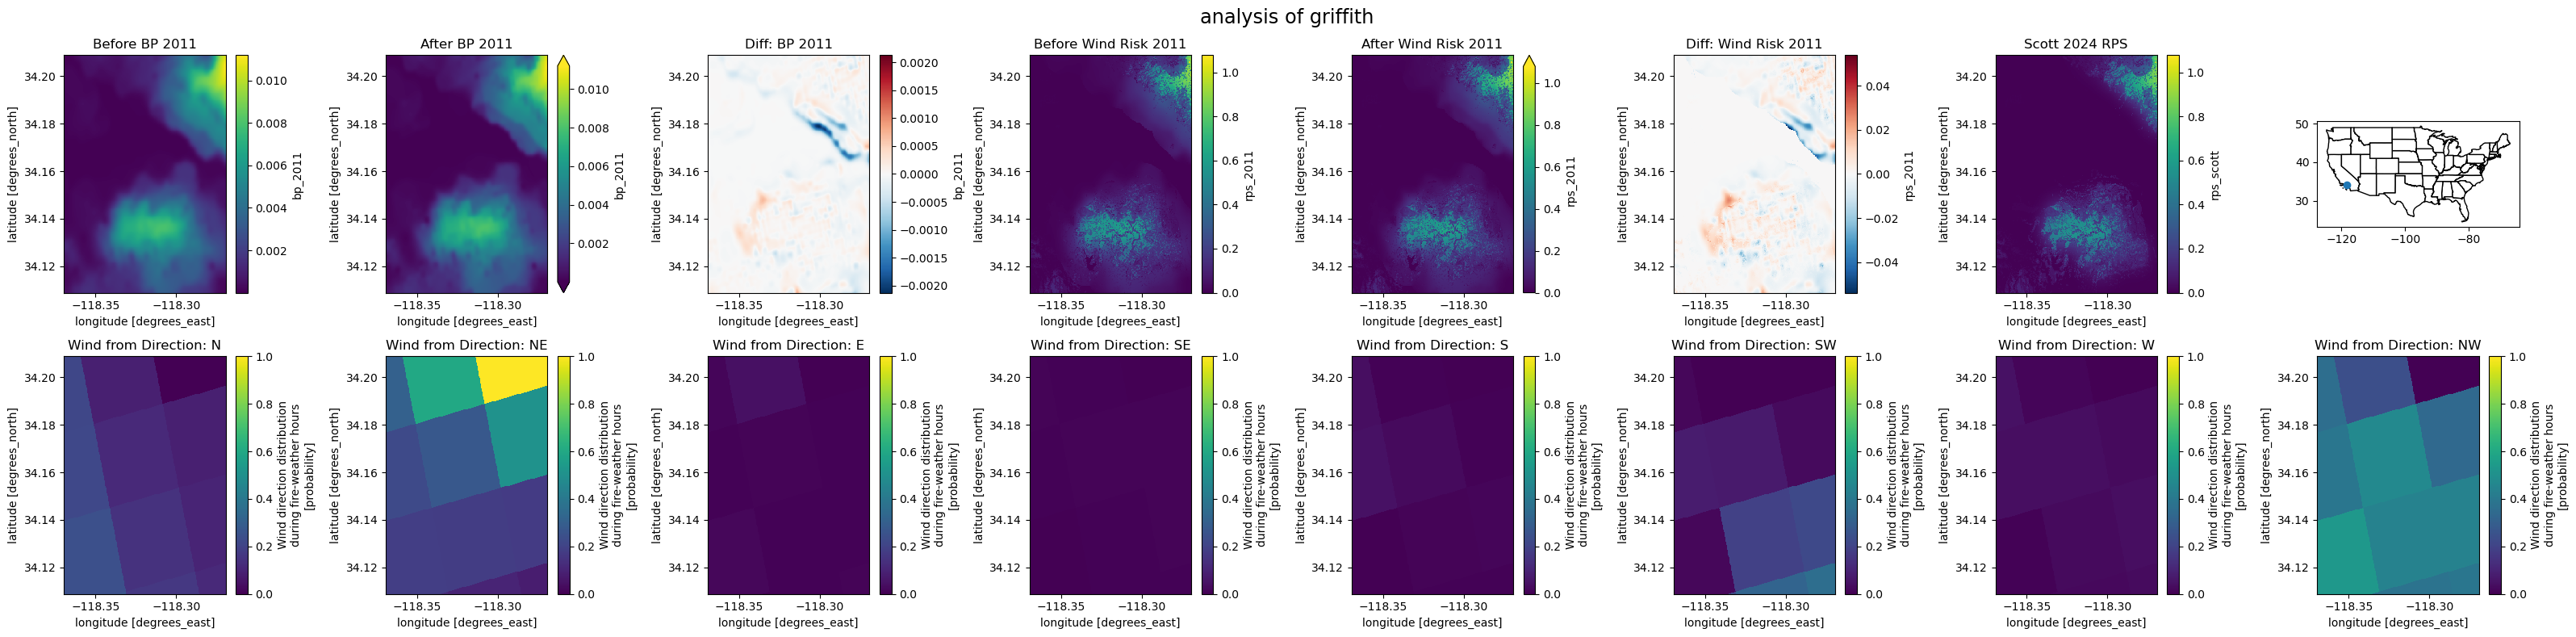

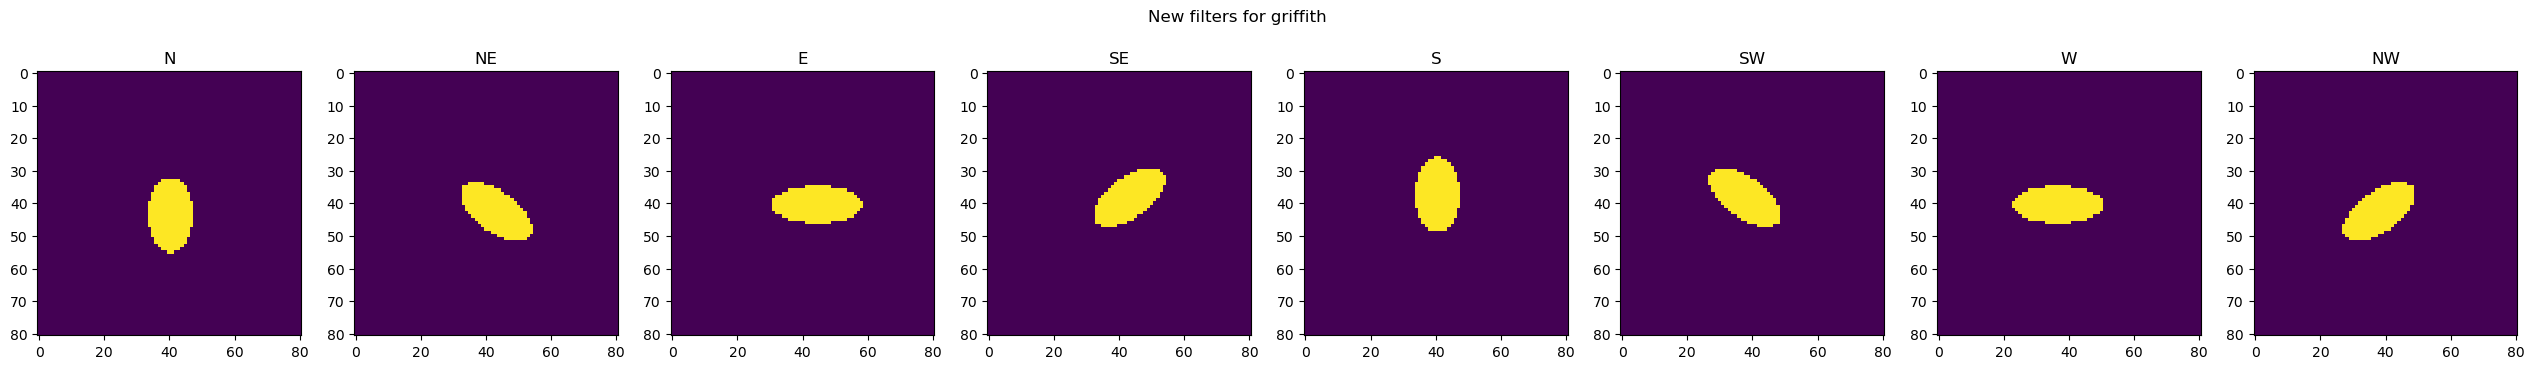

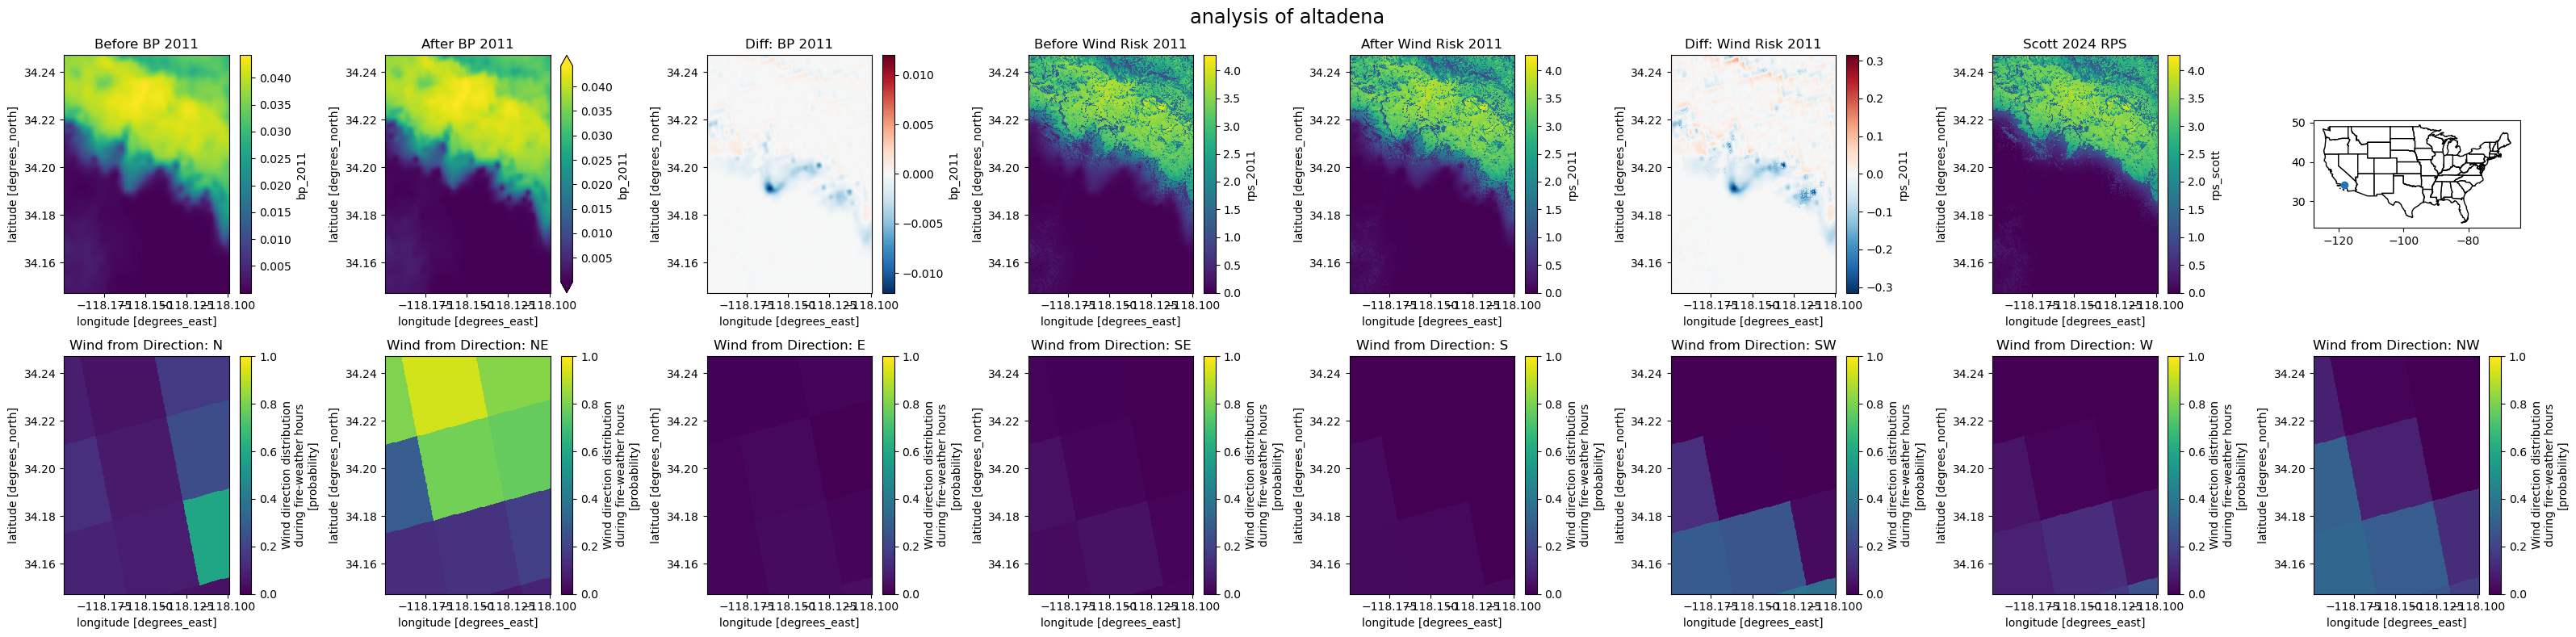

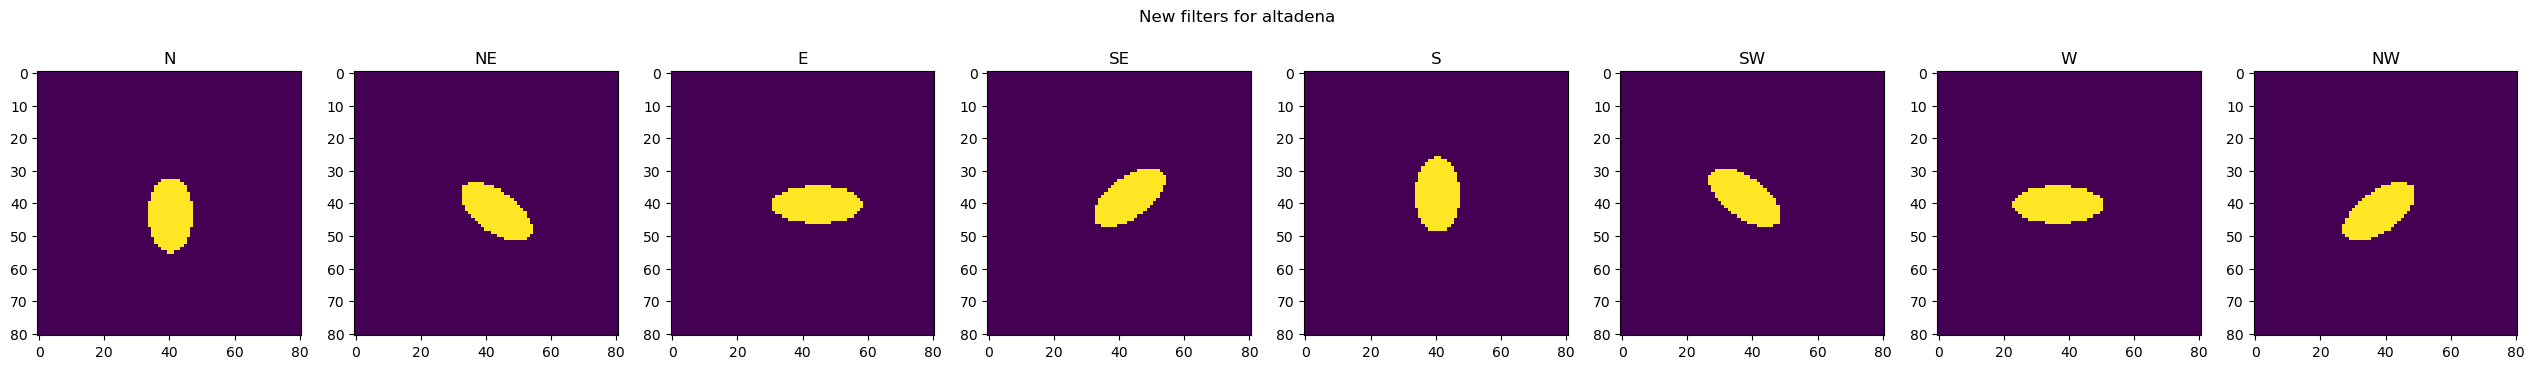

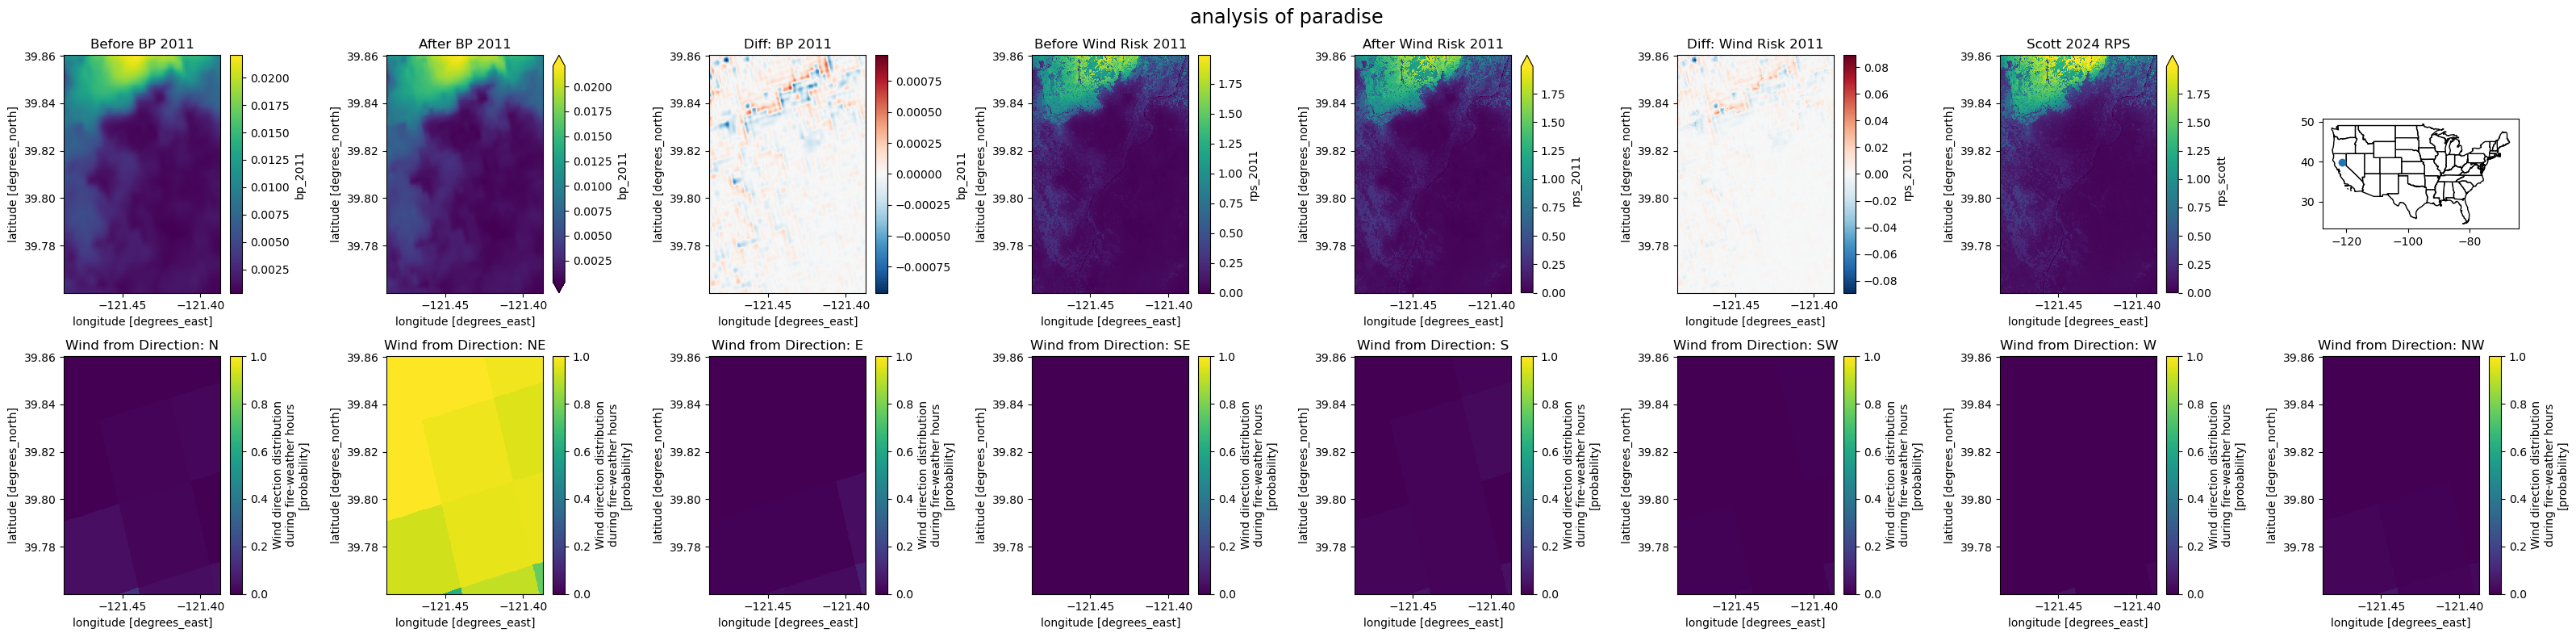

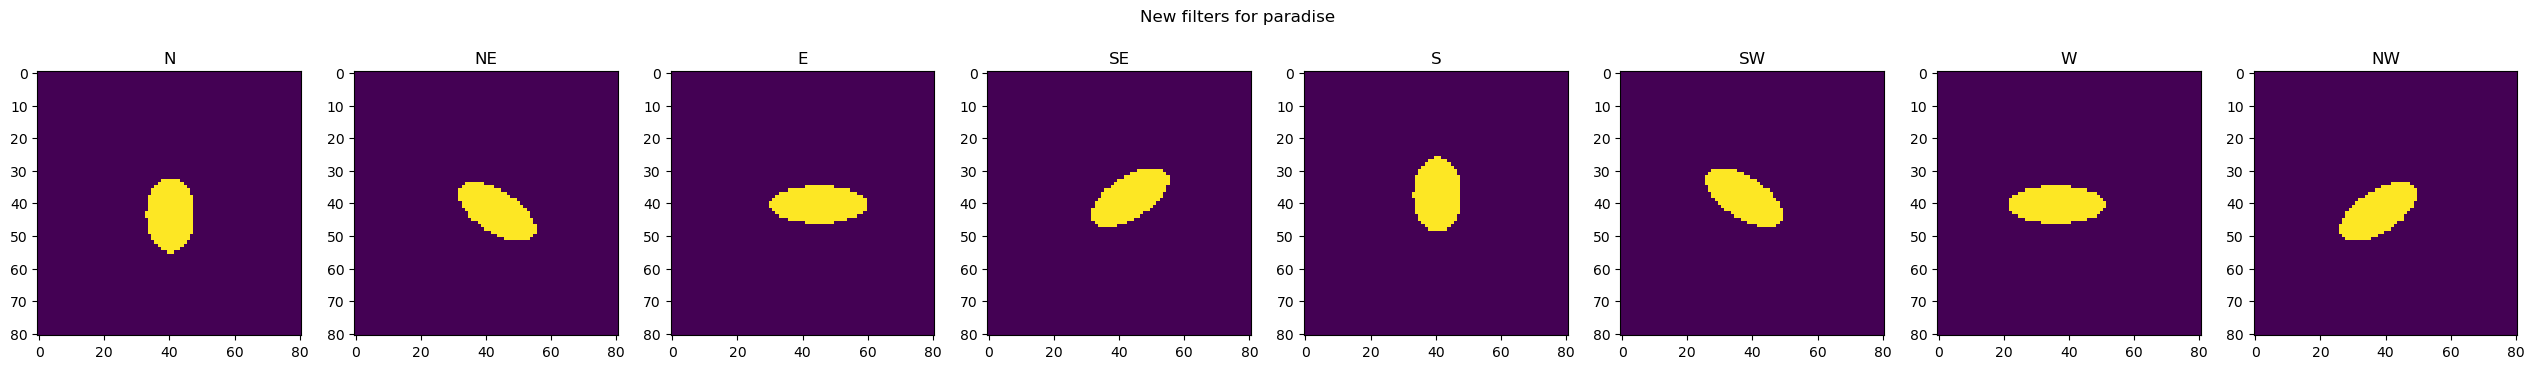

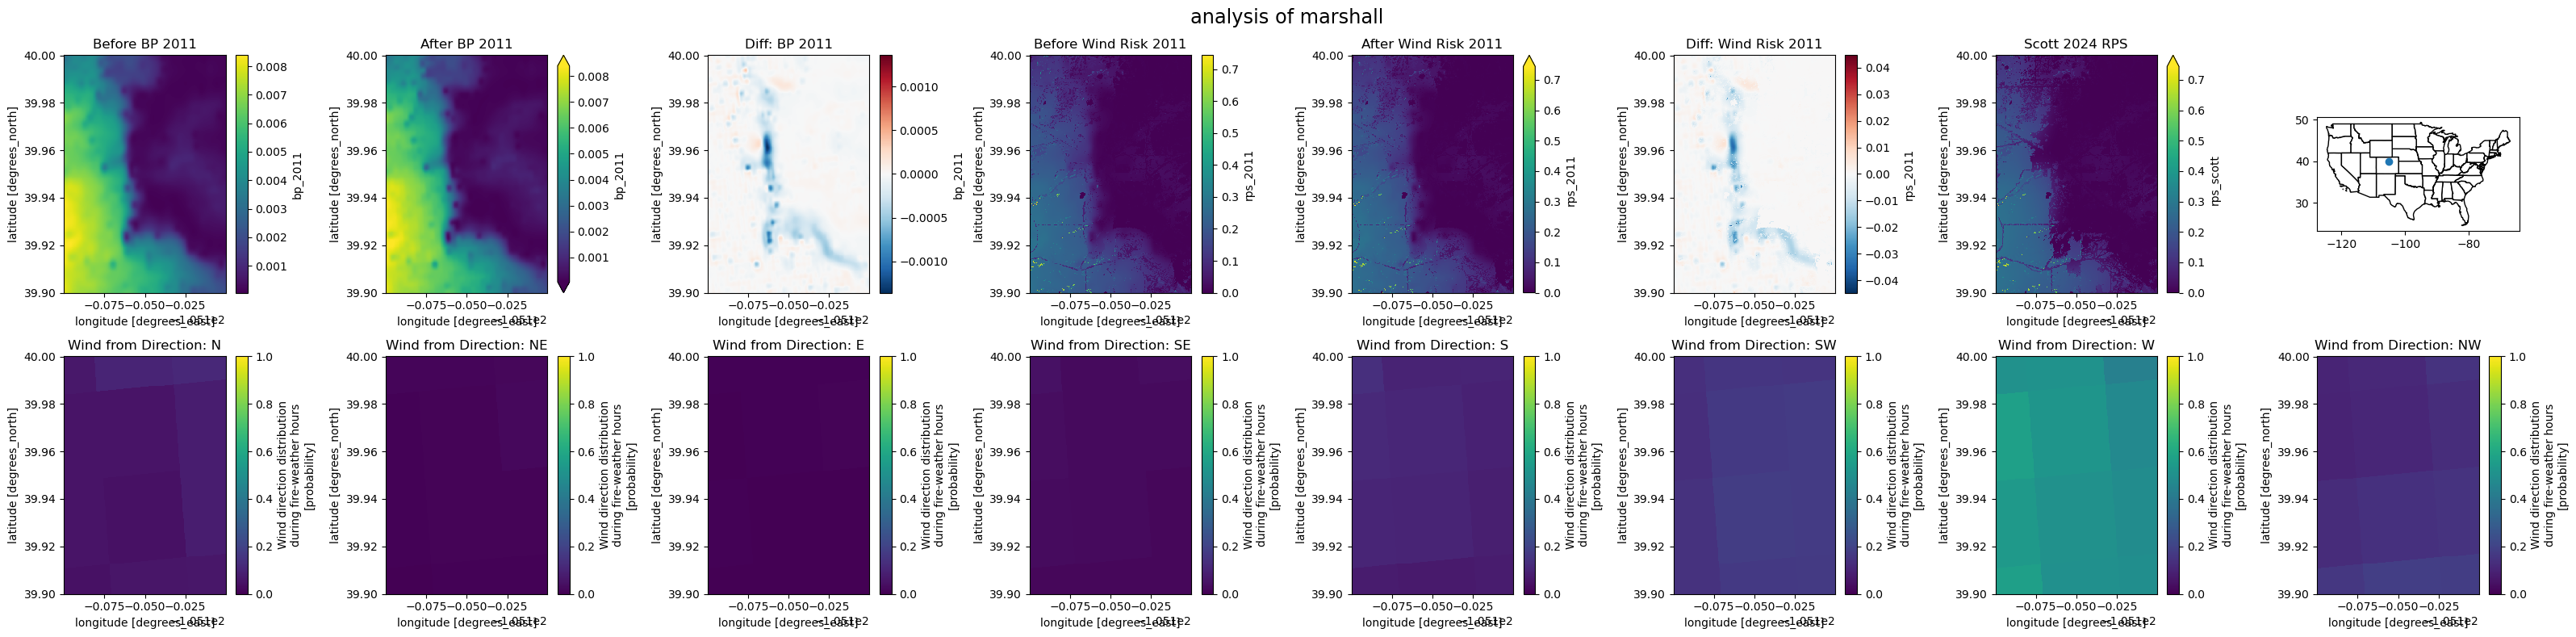

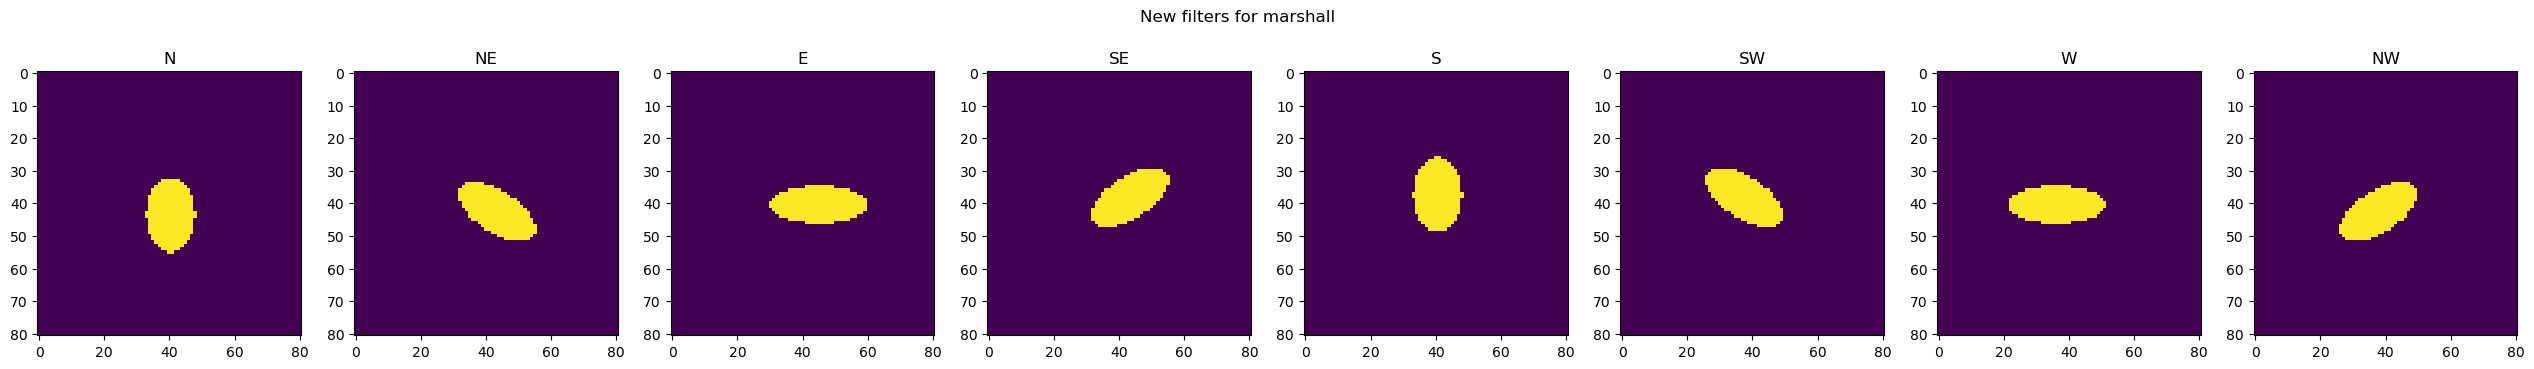

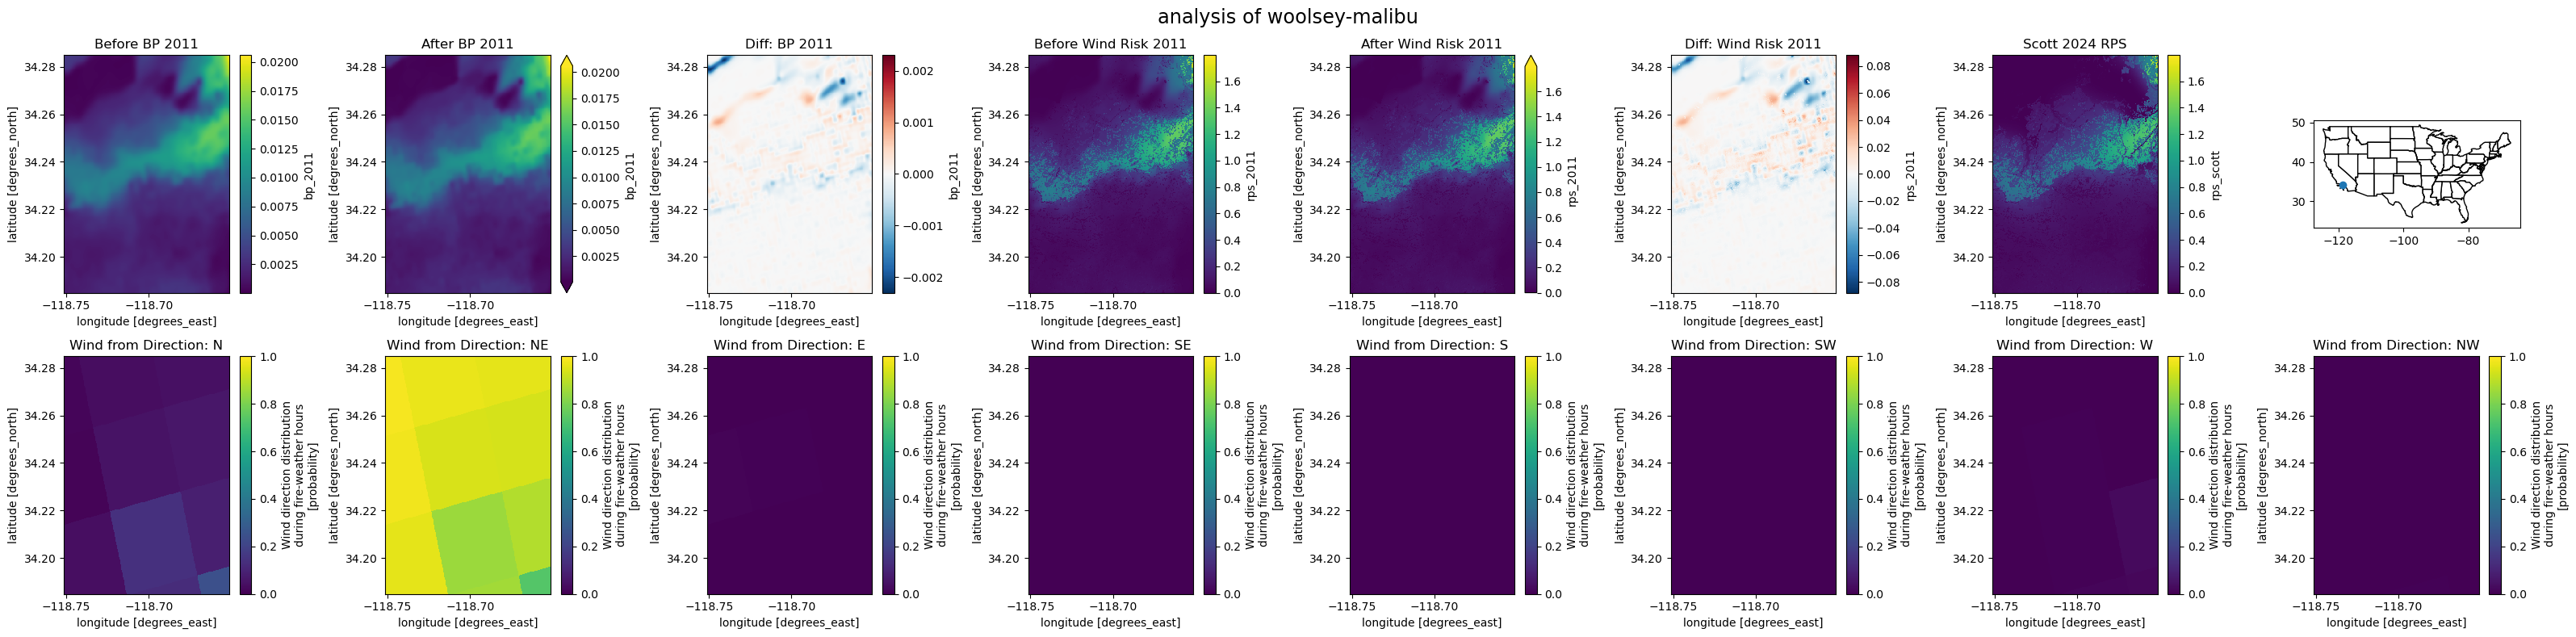

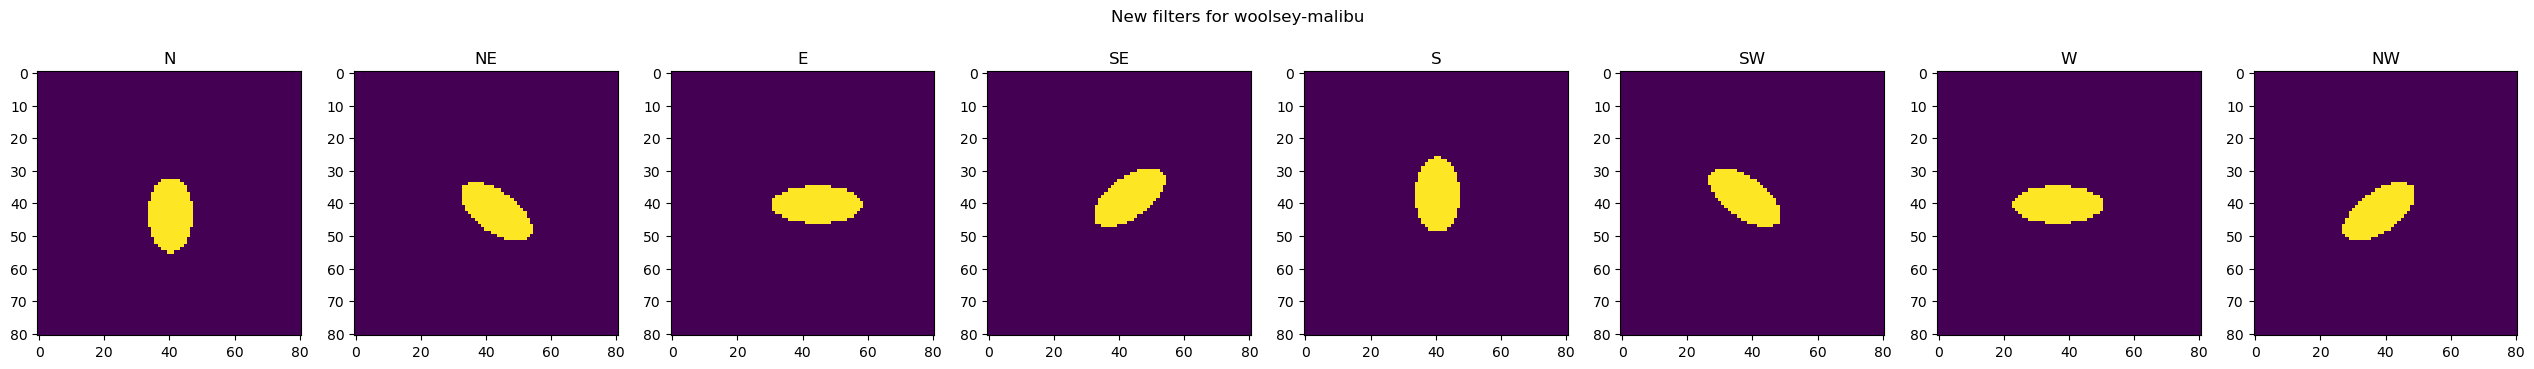

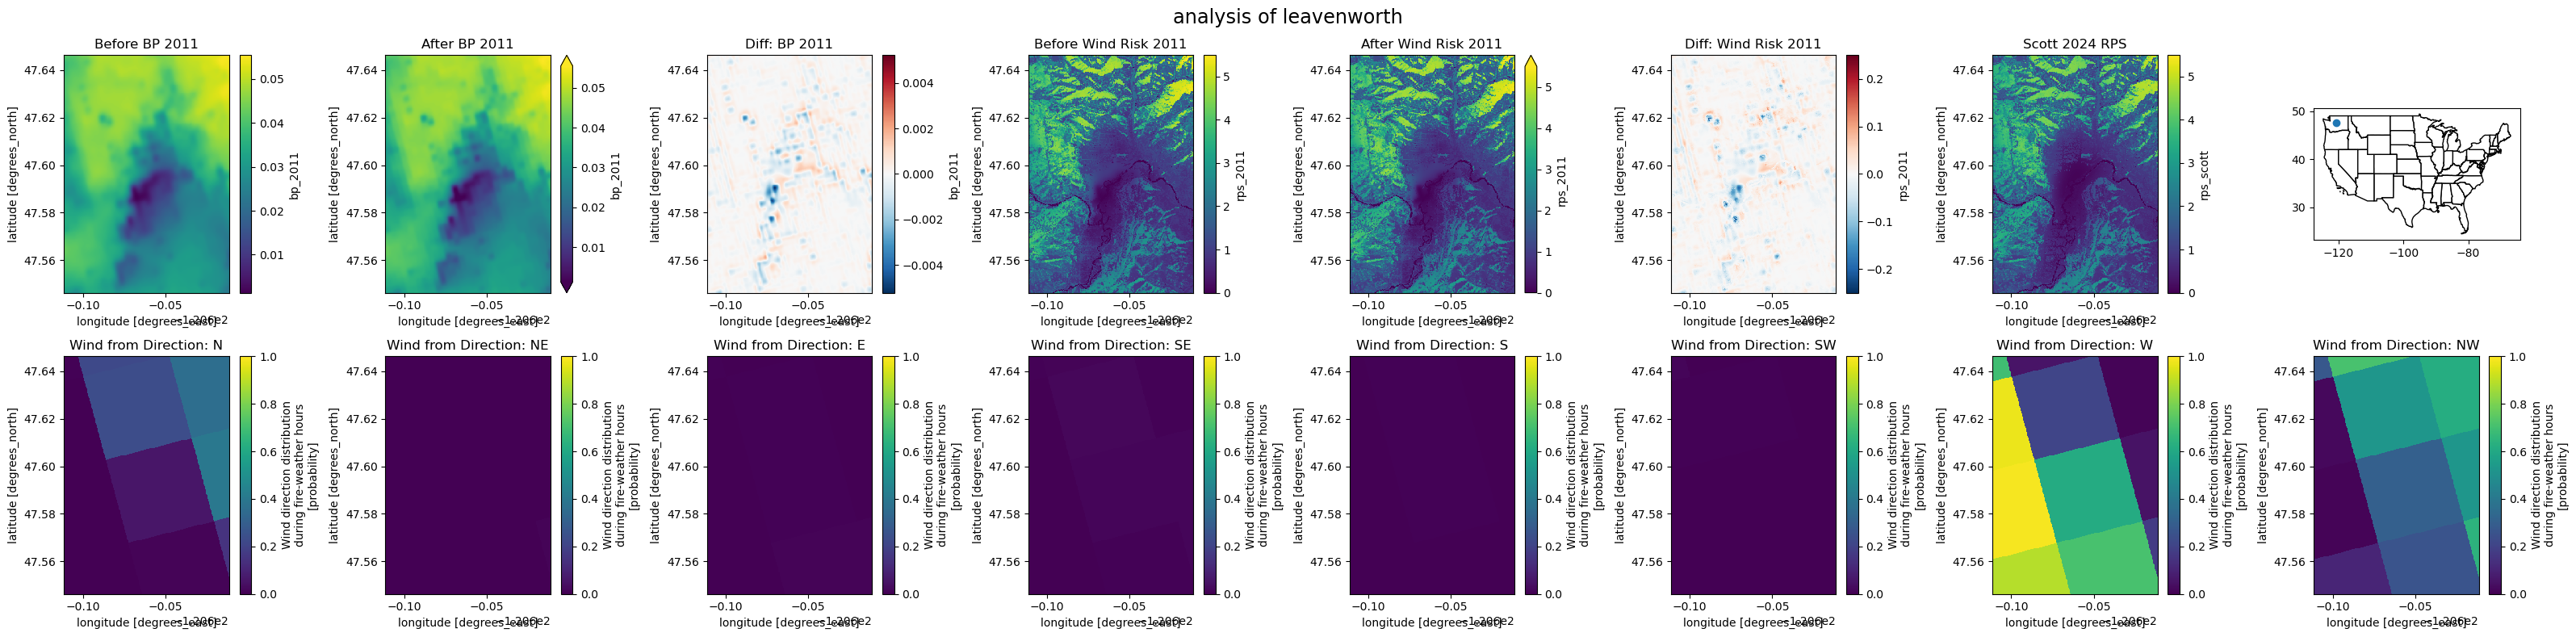

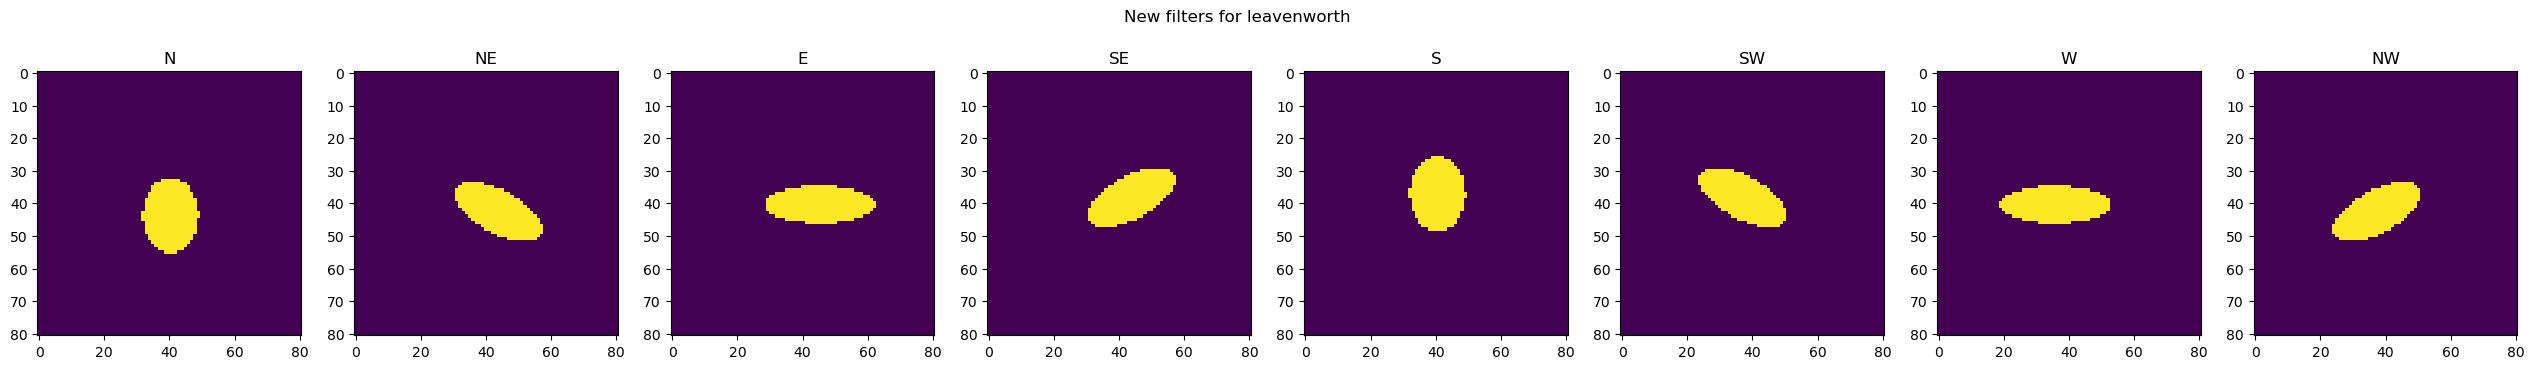

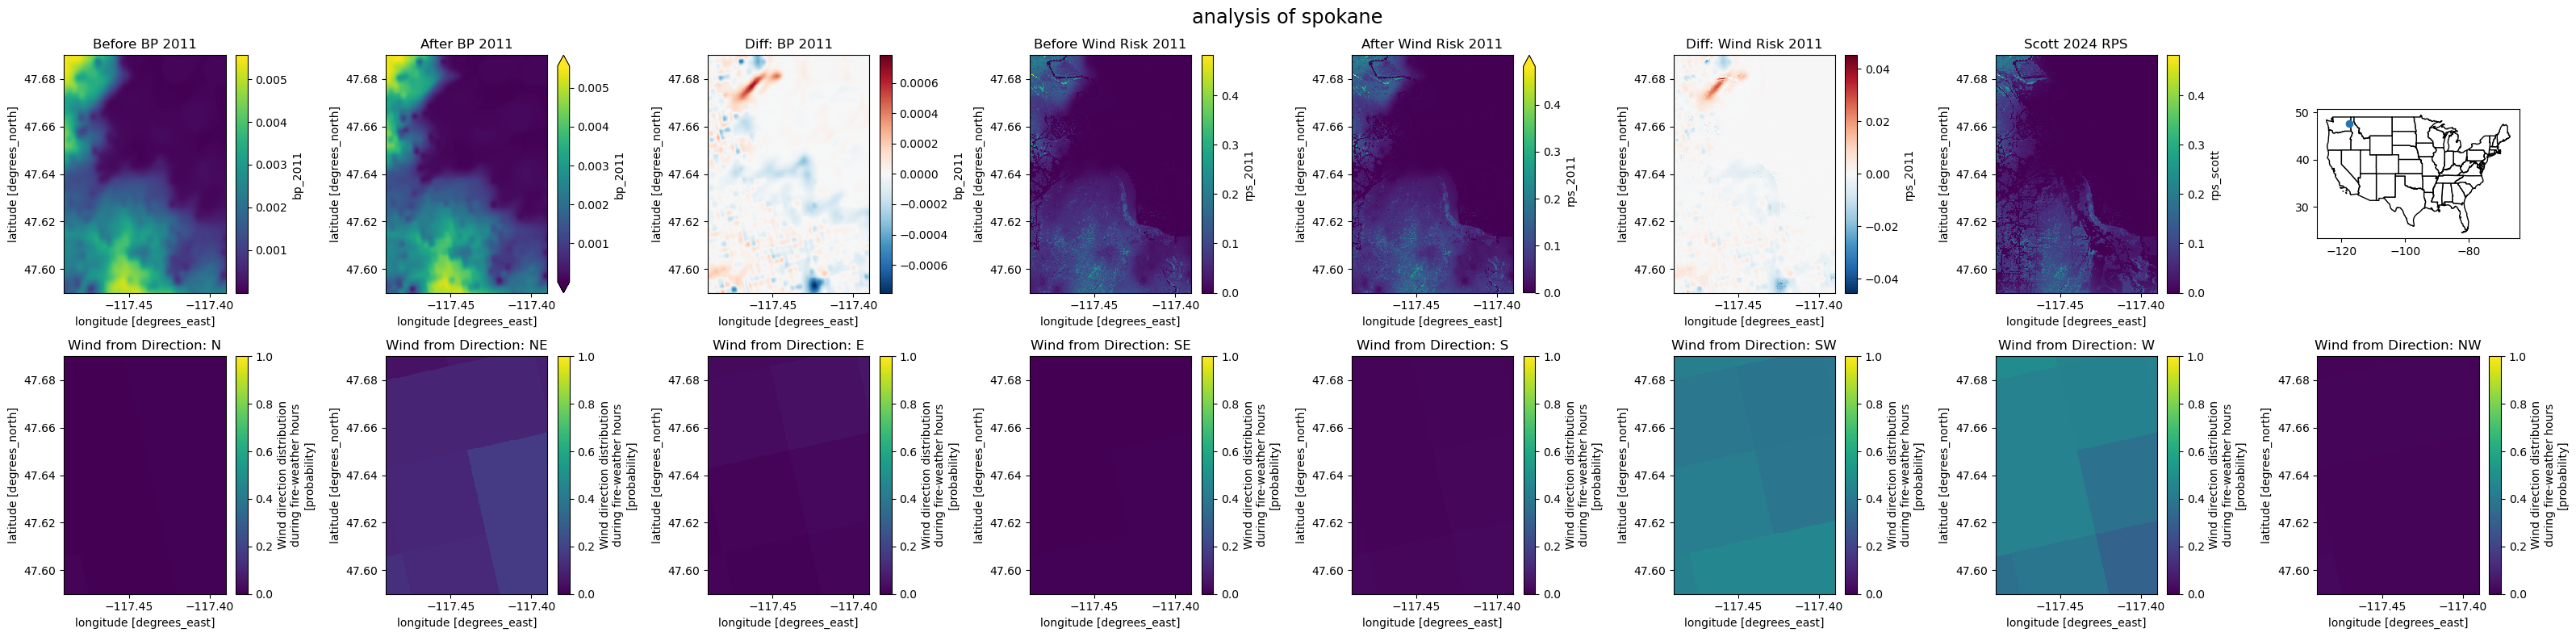

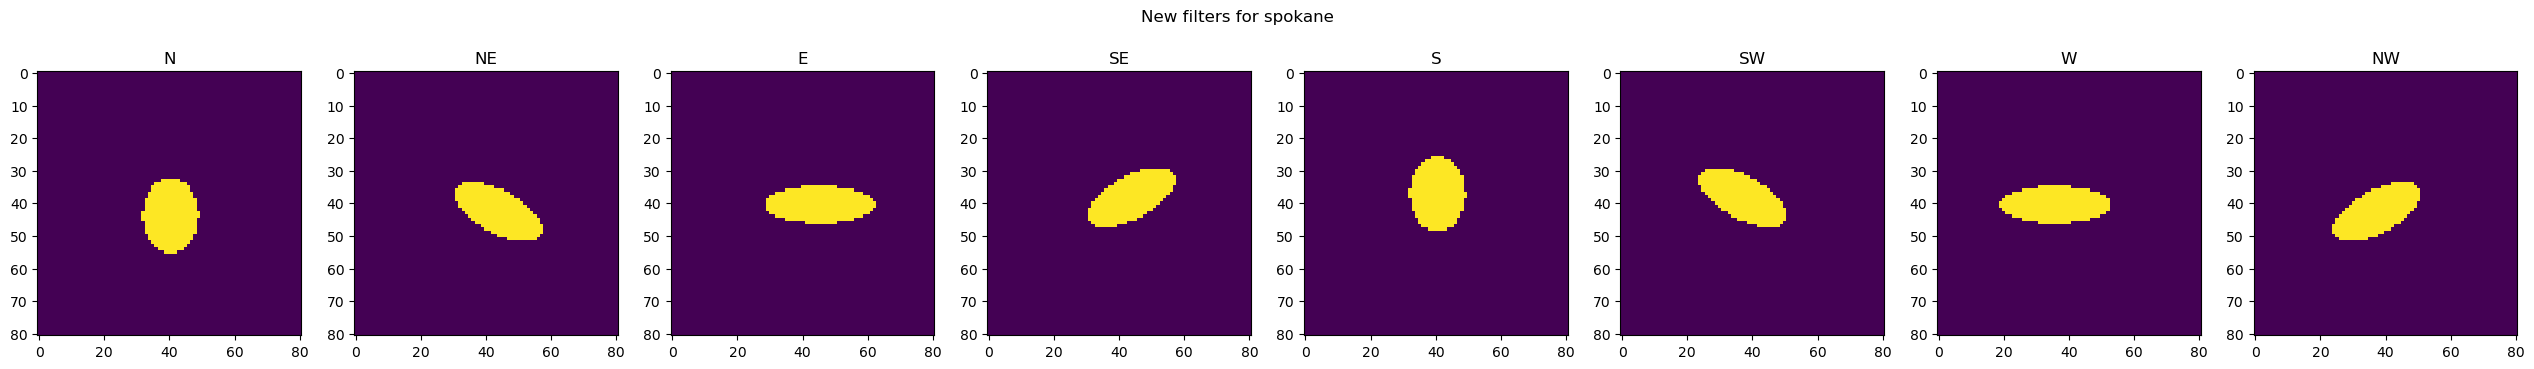

In [18]:
for location, (lat, lon) in locations.items():
    lat_slice = slice(lat - 0.05, lat + 0.05)
    lon_slice = slice(lon - 0.05, lon + 0.05)
    evaluate_bounding_box_before_after(
        lat_slice, lon_slice, ds_before, ds_after, title=f'analysis of {location}'
    )
    plot_filters(lat, lon, latitude_increment, longitude_increment)